# General data reader for AQUA 
## Spatial regridding

The reader includes also regridding functionality. The idea of the regridder (which uses sparse matrix multiplication) is to generate first the weights for the interpolation (an operation which needs to be done only once) and then to use them for each regridding operation.

The regridding weights are generated automatically by the reader if not already existant and stored in a directory specified in a machine-specific `config/machines/<machine-name>/regrid.yaml` file, where `<machine-name>` is the name of the current machine (e.g. "levante"). The same file also contains a list of predefined target grids (only regular lon-lat for now). For example "r100" is a regular grid at 1° resolution. New target grids can be defined in `regrid.yaml`. Since CDO is used to generate the weights, also a sample target file could be used. The precomputed weights are stored in a directory also specified in the `regrid.yaml` configuration file for each machine. This directory could be shared among the members of a research group in order to reduce the need to recompute the weights.

3D weights are particularly expensive in termso of computation and memory. We suggest to run the first instance of the weights generation process (the first time you initialize the Reader for a data source and a specific target grid) on a dedicated computing node. For example, if `nproc=16` computing cores are used (the default - this spawns 16 parallel cdo processes) for FESOM NG5 data, up to about 170 GB of memory will be needed and the calculation will last about 10 minutes. This will need to be done only once, to precompute the weights.

CDO is used for generating the weights and it will be needed in your environment. CDO is not needed to use the regridder, only to generate the weights. The regridder configuration file also stores for now (this may be modified in the future) information on files containing a grid description for different data sources. A fixed path to the CDO executable for each machine can be specified in the `config/config.yaml` file. If not specified the system `$PATH` will be used.

For regridding to work you will need the external [smmregrid](https://github.com/jhardenberg/smmregrid) module.

In [1]:
from aqua import Reader

### Example 1: ERA5

We load ERA5 data specifying that we wish to regrid them to a 2° grid.

In [2]:
reader = Reader(model="ERA5", exp="era5", source="monthly", regrid="r200")
data = reader.retrieve()

/LUMI_TYKKY_ZOMGa5S/miniconda/envs/env1/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
2024-02-12 17:43:44 :: eccodes :: WARNING  -> ShortName tprate has multiple grib codes associated: ['260048', '172228']
2024-02-12 17:43:44 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right
2024-02-12 17:43:44 :: eccodes :: WARNING  -> ShortName tcc has multiple grib codes associated: ['228164', '164']
2024-02-12 17:43:44 :: eccodes :: WARNING  -> AQUA will take the first so that tcc -> 228164, please set up a correct fix if this does not look right


by default, the data are still on the raw original grid. Let's look at temperature

In [3]:
data["2t"]

<xarray.DataArray '2t' (time: 996, lat: 721, lon: 1440)>
dask.array<getitem, shape=(996, 721, 1440), dtype=float32, chunksize=(12, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2022-12-01
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:  2 metre temperature
    units:      K
    code:       167
    table:      128
    history:    \n2024-02-12 17:43:44 AQUA💧: Variable renamed 2t by fixer;\n2...
    paramId:    167
    cfVarName:  t2m
    shortName:  2t

... but we can now ask to regrid it (or part of it) to the destination grid which we chose when we instantiated the reader.

/LUMI_TYKKY_ZOMGa5S/miniconda/envs/env1/lib/python3.11/site-packages/sparse/_coo/core.py:215: DeprecationWarning: coords should be an ndarray. This will raise a ValueError in the future.
  warnings.warn(


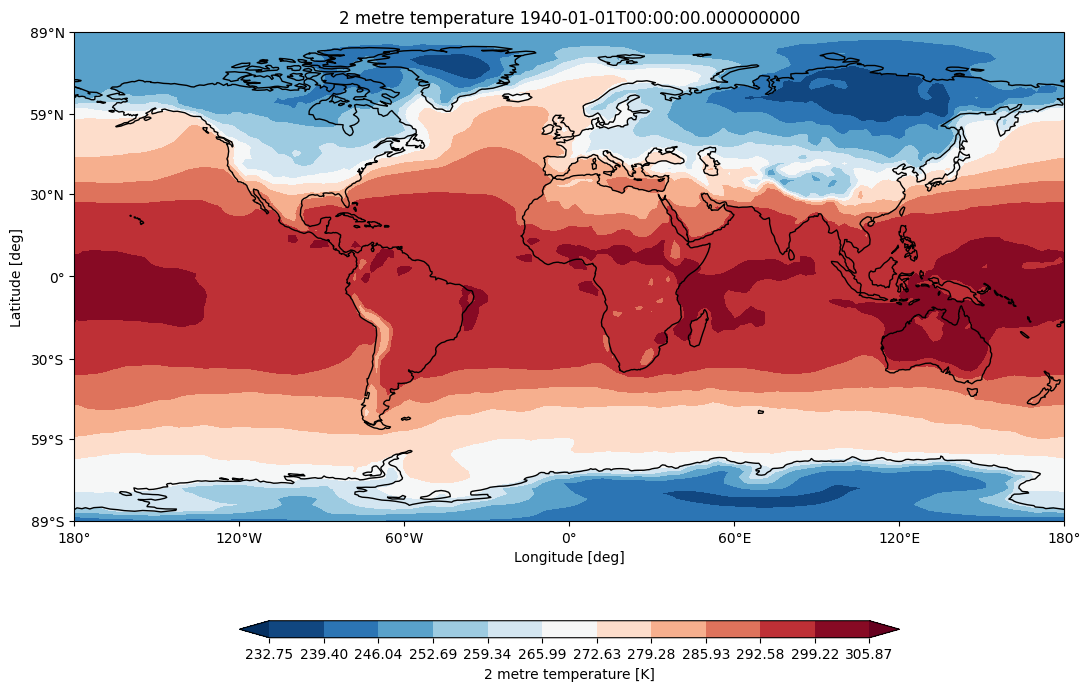

In [4]:
data["2t"].isel(time=0).aqua.regrid().aqua.plot_single_map()

### Example 2: CERES

Instantiate a reader for CERES data specifying that we will want to interpolate to a 2 deg grid (the grids are defined in the `regrid.yaml` file and the weights saved in a special directory). If the weights file does not already exist in our collection it will be created automatically.

In [5]:
from aqua import Reader, catalogue
reader = Reader(model="CERES", exp="ebaf-sfc41", source="monthly", regrid="r200")

Load the actual data. By default these data have not been regridded yet. 

In [6]:
data = reader.retrieve()

/LUMI_TYKKY_ZOMGa5S/miniconda/envs/env1/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


By default these data have not been regridded yet

In [36]:
data

<xarray.Dataset>
Dimensions:                (time: 265, lon: 360, lat: 180)
Coordinates:
  * time                   (time) datetime64[ns] 2000-03-15 ... 2022-03-15
  * lon                    (lon) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * lat                    (lat) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Data variables: (12/32)
    toa_sw_clr_t_mon       (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_lw_clr_t_mon       (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_net_clr_t_mon      (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_cre_sw_mon         (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_cre_lw_mon         (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_cre_net_mon        (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    ...                     ...
    sfc_net_tot_clr_t_mon  (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    sfc_cre_net_sw_mon     (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    sfc_cre_net_lw_mon     (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    sfc_cre_net_tot_mon    (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    msnlwrf                (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    msnswrf                (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.4
    institution:  NASA Langley Research Center
    title:        CERES EBAF TOA and Surface Fluxes. Monthly Averages and 07/...
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.1; Release Date June 8, 2021
    DOI:          10.5067/TERRA-AQUA/CERES/EBAF_L3B004.1
    history:      Mon Jan 16 07:55:23 2023: cdo -mergetime CERES_EBAF_Ed4.1_S...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

Now we actually regrid part of the data (the first 96 frames)

In [7]:
tasr = data.msnlwrf.isel(time=slice(0,96)).aqua.regrid()

In [8]:
tasr

<xarray.DataArray 'msnlwrf' (time: 96, lat: 90, lon: 180)>
dask.array<reshape, shape=(96, 90, 180), dtype=float64, chunksize=(96, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-03-15 2000-04-15 ... 2008-02-15
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Attributes: (12/13)
    standard_name:  Surface Net Longwave Flux - All-Sky
    long_name:      Mean surface net long-wave radiation flux
    units:          W m-2
    CF_name:        surface_net_downward_longwave_flux
    comment:        none
    valid_min:           -300.000
    ...             ...
    history:        \n2024-02-12 17:44:31 AQUA💧: Variable msnlwrf, derived wi...
    paramId:        235038
    cfVarName:      msnlwrf
    shortName:      msnlwrf
    derived:        0.-sfc_net_lw_all_mon
    regridded:      1

/LUMI_TYKKY_ZOMGa5S/miniconda/envs/env1/lib/python3.11/site-packages/sparse/_coo/core.py:215: DeprecationWarning: coords should be an ndarray. This will raise a ValueError in the future.
  warnings.warn(
/LUMI_TYKKY_ZOMGa5S/miniconda/envs/env1/lib/python3.11/site-packages/sparse/_coo/core.py:215: DeprecationWarning: coords should be an ndarray. This will raise a ValueError in the future.
  warnings.warn(
/LUMI_TYKKY_ZOMGa5S/miniconda/envs/env1/lib/python3.11/site-packages/sparse/_coo/core.py:215: DeprecationWarning: coords should be an ndarray. This will raise a ValueError in the future.
  warnings.warn(
/LUMI_TYKKY_ZOMGa5S/miniconda/envs/env1/lib/python3.11/site-packages/sparse/_coo/core.py:215: DeprecationWarning: coords should be an ndarray. This will raise a ValueError in the future.
  warnings.warn(


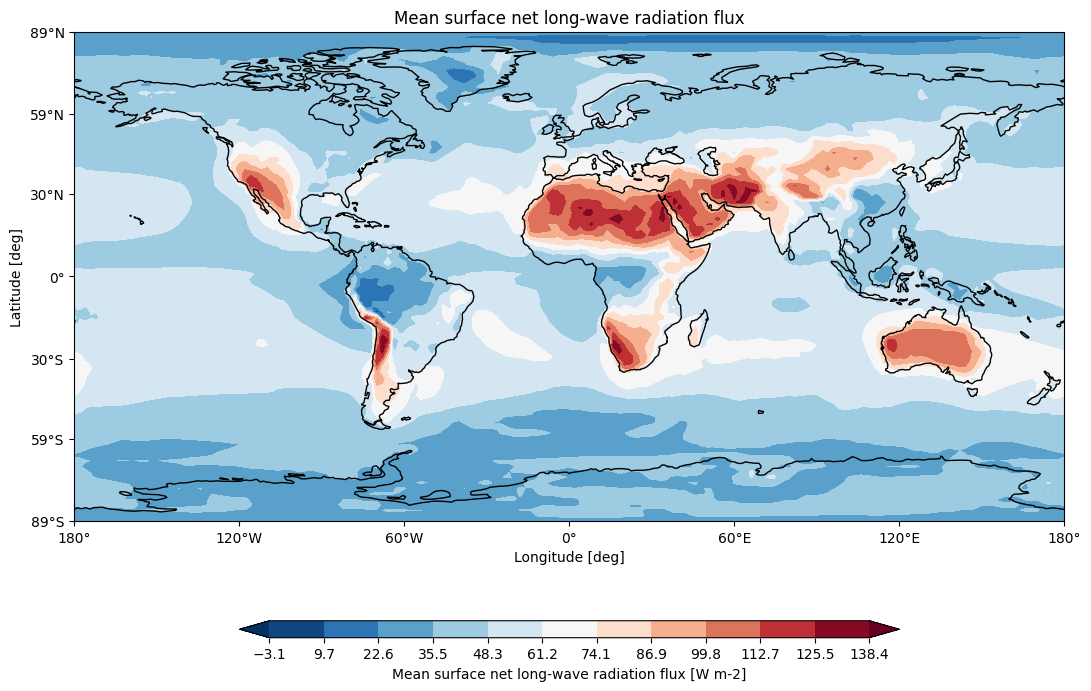

In [9]:
tasr.mean("time").aqua.plot_single_map()

### Example 3: WOA18 data - further interpolation

In [70]:
from aqua import Reader
reader = Reader(model="WOA18", exp="woa18_2005_2017", source="annual", regrid="r100")
data = reader.retrieve()

2024-02-12 19:42:06 :: Reader :: ERROR    -> The requested deafult fixer name WOA18-default does not exist in fixes files
2024-02-12 19:42:06 :: Reader :: WARNING  -> No fixes available for model WOA18, experiment woa18_2005_2017, source annual
/LUMI_TYKKY_ZOMGa5S/miniconda/envs/env1/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
2024-02-12 19:42:07 :: Reader :: ERROR    -> Variable crs has no units!
2024-02-12 19:42:07 :: Reader :: ERROR    -> Variable lat_bnds has no units!
2024-02-12 19:42:07 :: Reader :: ERROR    -> Variable lon_bnds has no units!
2024-02-12 19:42:07 :: Reader :: ERROR    -> Variable depth_bnds has no units!
2024-02-12 19:42:07 :: Reader :: ERROR    -> Variable climatology_bounds has n

In [71]:
data.t_an.isel(depth=0).aqua.regrid()

<xarray.DataArray 't_an' (time: 1, lat: 180, lon: 360)>
dask.array<getitem, shape=(1, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    depth      float32 0.0
  * time       (time) float32 726.0
    idx_depth  int64 0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius
    regridded:      1
    history:        \n2024-02-12 19:42:54 AQUA💧: Regrid from woa to r100;\n

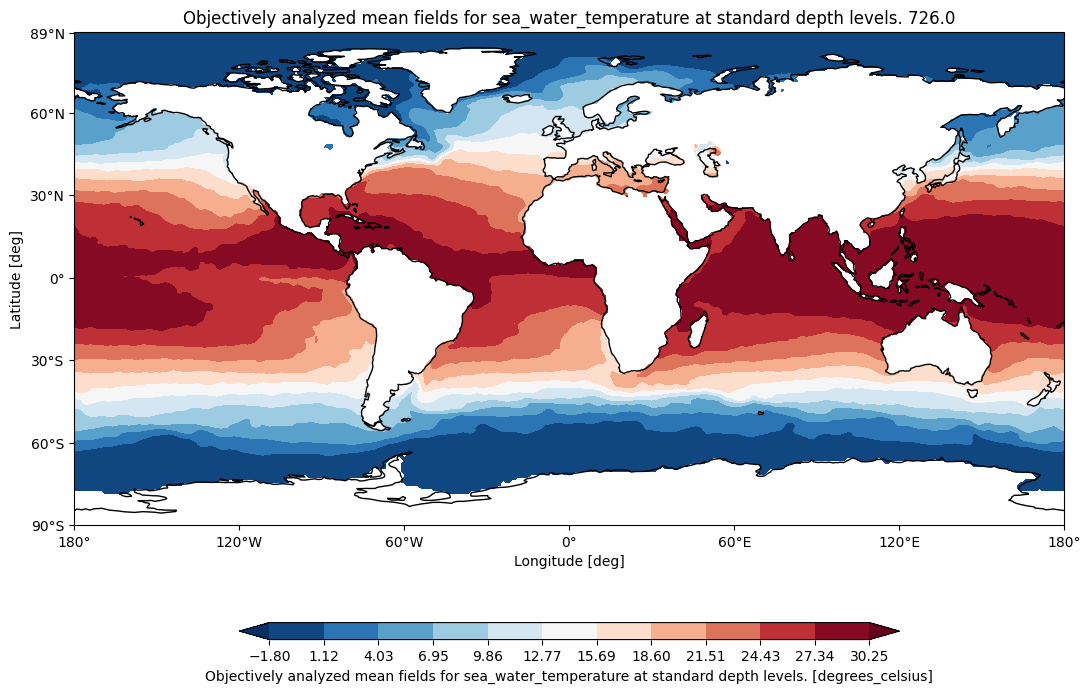

In [73]:
data.t_an.isel(time=0).isel(depth=0).aqua.regrid().aqua.plot_single_map()

### Example 4: PSC data - further interpolation

The regridder can also deal with 3D masked fields, thanks to new functionality in *smmregrid*.

This functionality now works with any input source, even if it contains multiple vertical coordinates.
Let's show this loading original 3D FESOM data. 

Please be advised that calculation of the weights (which will be done only the first time, if weights are not available) is a very memory-intensive task (a full node on levante with 256GB memory may be needed for 3D FESOM data from the tco2559 experiment). Using 16 cores (by default) generation of weights for FESOM, with two vertical coordinates, may take about 40 minutes, so please be patient. 

The weights for the "r100" grid (1° regular grid) case have been precomputed on levante.

In [55]:
from aqua import Reader
reader = Reader(model="PSC", exp="PIOMAS", source="monthly", regrid='r050')

/LUMI_TYKKY_ZOMGa5S/miniconda/envs/env1/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
2024-02-12 19:35:57 :: Reader :: WARNING  -> Grid file is not defined, retrieving the source itself...
2024-02-12 19:35:57 :: Reader :: WARNING  -> Weights file not found: /pfs/lustrep3/projappl/project_465000454/data/AQUA/weights/weights_PSC_PIOMAS_monthly_bil_r050_l2d.nc
2024-02-12 19:35:57 :: Reader :: WARNING  -> Attempting to generate it ...
2024-02-12 19:36:00 :: Reader :: WARNING  -> Success!


The reader loaded the precomputed 3D weights (pointing to `weights_FESOM_tco2559-ng5_original_3d_ycon_r100_l3d.nc` for example) and organizes them in a dictionary according to the vertical coordinate ("2d" for 2D variables)

In [56]:
reader.weights

{'2d': <xarray.Dataset>
 Dimensions:              (src_grid_rank: 2, dst_grid_rank: 2,
                           src_grid_size: 43200, dst_grid_size: 259200,
                           num_links: 1036800, num_wgts: 1)
 Dimensions without coordinates: src_grid_rank, dst_grid_rank, src_grid_size,
                                 dst_grid_size, num_links, num_wgts
 Data variables: (12/14)
     src_grid_dims        (src_grid_rank) int32 dask.array<chunksize=(2,), meta=np.ndarray>
     dst_grid_dims        (dst_grid_rank) int32 dask.array<chunksize=(2,), meta=np.ndarray>
     src_grid_center_lat  (src_grid_size) float64 dask.array<chunksize=(43200,), meta=np.ndarray>
     dst_grid_center_lat  (dst_grid_size) float64 dask.array<chunksize=(259200,), meta=np.ndarray>
     src_grid_center_lon  (src_grid_size) float64 dask.array<chunksize=(43200,), meta=np.ndarray>
     dst_grid_center_lon  (dst_grid_size) float64 dask.array<chunksize=(259200,), meta=np.ndarray>
     ...                   ...
 

We can now retrieve the data

In [57]:
data = reader.retrieve()
data

<xarray.Dataset>
Dimensions:    (time: 528, y: 120, x: 360)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-15 1979-02-15 ... 2022-12-15
    lon        (y, x) float32 319.5 320.5 321.5 322.5 ... 317.9 318.4 318.8
    lat        (y, x) float32 48.99 48.99 48.99 48.99 ... 72.71 72.71 72.71
Dimensions without coordinates: y, x
Data variables:
    avg_sivol  (time, y, x) float32 dask.array<chunksize=(1, 120, 360), meta=np.ndarray>
    areacello  (y, x) float32 dask.array<chunksize=(120, 360), meta=np.ndarray>
    sftof      (y, x) float32 dask.array<chunksize=(120, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Dec 04 10:12:22 2023: cdo -settunits,days /work/bb1153/...
    CDO:          Climate Data Operators version 2.0.3 (https://mpimet.mpg.de...

and regrid them

In [52]:
from aqua.util import area_selection

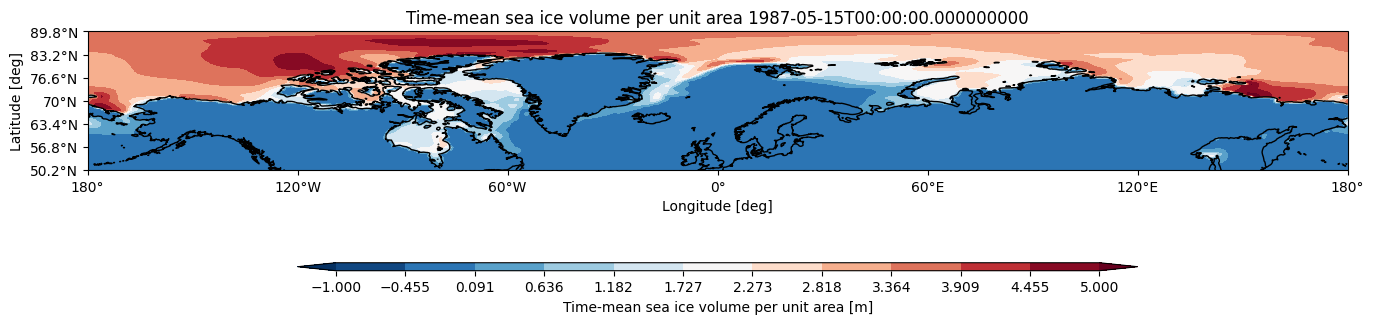

In [67]:
lon_lim = (0, 360)
lat_lim = (50, 90)

data_r = data.avg_sivol.isel(time=100).aqua.regrid()
sel_box = area_selection(data_r, lon=lon_lim, lat=lat_lim, drop=True)
sel_box.aqua.plot_single_map(vmin=-1, vmax=5,  figsize=(14, 4))

We can also ask the regridder to regrid all variables at once upon retrieval (in this case the data include variables depending on two different vertical coordinates):

### Example 5: EN4

We can also regrid ICON Healpix data from NextGEMS Cycle 3. Here an example for three different zoom level (i.e. grid hierarchy, with 0 as the coarser)

/LUMI_TYKKY_ZOMGa5S/miniconda/envs/env1/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


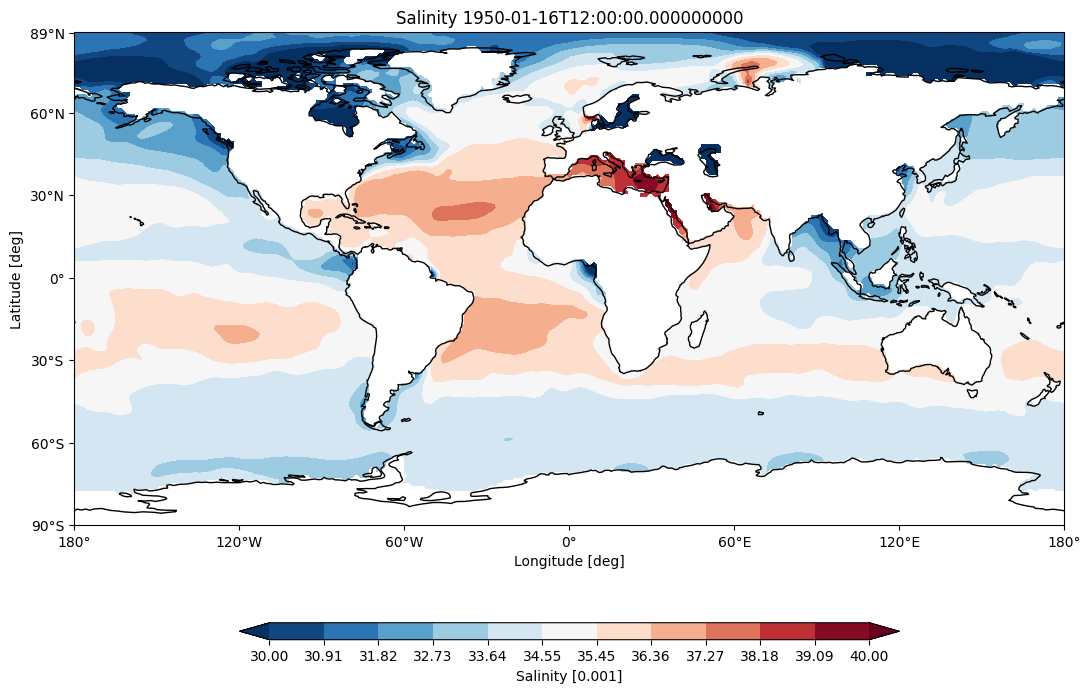

In [60]:
from aqua import Reader
reader = Reader(model="EN4", exp="en4", source="monthly", regrid="r100", fix=False)
data = reader.retrieve(var='so')
data['so'].isel(lev=0).aqua.regrid().isel(time=0).aqua.plot_single_map(vmin=30, vmax=40)